<h1>Brant Et Pavlovic Imotion-based Sentiment Classifier Omgit'ssogood</h1>

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import LSTM

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from collections import Counter
import math

import tweepy
import requests

Using TensorFlow backend.


<h2> Data Import and Cleaning </h2>

In [19]:
# get that data
def load_txt_data(paths):
    data_list = []
    for dataset in paths:
        with open(dataset, 'r') as data:
            datas = data.readlines()
            for d in datas:
                data_list.append(d)
    return data_list

# might use the sets separately, might combine em and chop em up as i please, idk we'll see what happens
# these bois also need some good ol' fashioned cleaning (get rid of punctuation and end of lines)
kaggle_paths = ['data/kaggle_data/test.txt', 'data/kaggle_data/train.txt', 'data/kaggle_data/val.txt']
kaggle_data_precleaning = load_txt_data(kaggle_paths)
print(len(kaggle_data_precleaning))
print(kaggle_data_precleaning[:10])

dialog_path = 'data/dailydialog.csv'
dialog_df = pd.read_csv(dialog_path)
print(len(dialog_df))
print(dialog_df[:10])



20000
['im feeling rather rotten so im not very ambitious right now;sadness\n', 'im updating my blog because i feel shitty;sadness\n', 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her;sadness\n', 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived;joy\n', 'i was feeling a little vain when i did this one;sadness\n', 'i cant walk into a shop anywhere where i do not feel uncomfortable;fear\n', 'i felt anger when at the end of a telephone call;anger\n', 'i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia;joy\n', 'i like to have the same breathless feeling as a reader eager to see what will happen next;joy\n', 'i jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week 

In [20]:
# clean that data

#adding neg_ tags on words after not, no, ect.
def add_negation(toks):
    negwords = ['not', 'no', 'never']
    negtoks = []
    neg = False
    for tok in toks:
        if neg and tok not in string.punctuation:
            negtoks.append('not_' + tok)
        else:
            negtoks.append(tok)
        if 'n\'t' in tok or tok in negwords:
            neg = True
        if re.search(r'[,.?:;]', tok):
            neg = False
    return negtoks

def everything_before_semicolon(sent):
    idx = sent.find(";")
    if idx != -1:
        return sent[:idx]
    
def everything_after_semicolon(sent):
    idx = sent.find(";")
    if idx != -1:
        return sent[idx+1:len(sent)-1]

def clean_data(data):
    stemmer = PorterStemmer()
    
    #adding negation tagging to data
    cdata = [add_negation(sent) for sent in data]
    #removing punctuation
    cdata = [[re.sub(r'[^\w\s]', '', word) for word in sent] for sent in cdata]
    #stemming 
    cdata =[[stemmer.stem(word) for word in sent] for sent in cdata]
    #remove empty/space entries
    cdata = [[word for word in sent if not word.isspace() and word != ''] for sent in cdata]
    return cdata
    



dialog_data = [dialog.lower() for dialog in dialog_df['Text'].tolist()]
dialog_data = [re.sub(r'[.,?!:;]', '. ', sent).split() for sent in dialog_data]
kaggle_data = [everything_before_semicolon(sent).split() for sent in kaggle_data_precleaning]

merge_data = dialog_data + kaggle_data
merge_data = clean_data(merge_data)

# the daily dialog dataset has emotions encoded in nums from 0-6, as represented below
dialog_encodings = {0: "neutral", 1: "anger", 2: "disgust", 3: "fear", 4: "happiness", 5: "sadness", 6: "surprise"}


kaggle_emotions = [everything_after_semicolon(sent) for sent in kaggle_data_precleaning]
#editing labels to line up the two datasets better
kaggle_emotions = [word if word != 'joy' else 'happiness' for word in kaggle_emotions ]


dialog_emotions = [dialog_encodings[emotion] for emotion in dialog_df['Emotion']]


merge_emotions = dialog_emotions + kaggle_emotions

emo_dic = {'sadness': 0, 'fear': 1, 'disgust': 2, 'neutral': 3,'surprise': 4, 'happiness': 5, 'anger': 6, 'love': 7}

#removing sentences with more than 50 words, they are a small part of the dataset and significantly slow down
#our models
merge_drop = []
emo_drop = []
for i in range(0, len(merge_data)):
    if len(merge_data[i]) <= 50:
        merge_drop.append(merge_data[i])
        emo_drop.append(merge_emotions[i])
        
merge_data = merge_drop
merge_emotions = emo_drop


merge_df = pd.DataFrame({"Emotion": merge_emotions, 'Text':merge_data})

# get rid of a bunch of neutral datapoints bc there's waaaaay too many of 'em rn
emotion_counts = merge_df['Emotion'].value_counts()

neutrals_less = merge_df.loc[merge_df["Emotion"] == "neutral"][:emotion_counts[1]]

nm_data = []
nm_emo = []

for i in range(0, len(merge_data)):
    data = merge_data[i]
    emo = merge_emotions[i]
   
    if emo != "neutral" or data in list(neutrals_less["Text"]):
        nm_data.append(data)
        nm_emo.append(emo)

merge_data = nm_data
merge_emotions = nm_emo
merge_df = pd.DataFrame({"Emotion": merge_emotions, 'Text': merge_data})

X = merge_df['Text']
y = merge_df['Emotion']
y = [emo_dic[e] for e in y]



trainX, testX, trainy, testy = train_test_split(X, y, shuffle=True)
merge_df

,Emotion,Text
0,neutral,"[say, jim, how, about, go, for, a, few, beer, ..."
1,neutral,"[you, know, that, is, tempt, but, is, realli, ..."
2,neutral,"[what, do, you, mean, it, will, help, us, to, ..."
3,neutral,"[do, you, realli, think, so, i, dont, it, will..."
4,neutral,"[i, guess, you, are, right, but, what, shall, ..."
...,...,...
63772,sadness,"[im, have, ssa, examin, tomorrow, in, the, mor..."
63773,happiness,"[i, constantli, worri, about, their, fight, ag..."
63774,happiness,"[i, feel, it, import, to, share, thi, info, fo..."
63775,happiness,"[i, truli, feel, that, if, you, are, passion, ..."


<h2> Exploratory Data Analysis (graphs and what not) </h2>

<AxesSubplot:xlabel='Emotion', ylabel='Count'>

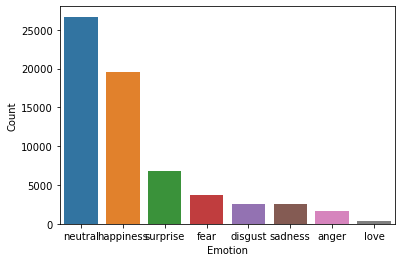

In [78]:
# graph that data

# spread of emotions
count_df = pd.DataFrame({"Emotion": pd.unique(merge_df['Emotion']), "Count": merge_df['Emotion'].value_counts()})
sns.barplot(data=count_df, x="Emotion", y="Count")
    

_"What makes a man turn neutral? Lust for gold? Power? Or were you just born with a heart full of neutrality?"_ - Zapp Brannigan

50


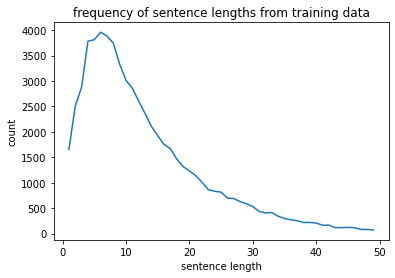

In [79]:
# check out the size of stuff for the embeddings for rnns so we know what kinda padding needs to go down
lens = [len(thing) for thing in merge_data]
max_len = max(lens)
min_len = min(lens)
print(max_len)
len_counts = [lens.count(i) for i in range(min_len, max_len)]

plt.plot(range(min_len, max_len), len_counts)
plt.title("frequency of sentence lengths from training data")
plt.xlabel("sentence length")
plt.ylabel("count")
plt.show()

The data is very heavily clustered/skewed toward the left, so we can probably drop all the datapoints with len of > ~50 - 75ish (makes no sense to pad everything up to 250ish for so few datapoints)

<h2> Statistical Model (Naive Bayes (Homie)) </h2>

In [48]:
# make that model
def calc_prob(num, denom):
    return math.log((num + 1) / denom, math.e)

'''
This implementation of Naive Bayes works by maintaining a count of occurences for every word in every class.
It uses these counts to calculate the relative probability of a sequence being in each class and classifies
that sequence into the class with highest probability
'''
class NaiveBayes:
    def __init__(self, num_classes):
        self.model = [Counter() for i in range(num_classes)]
        self.N = []
        self.nc = num_classes
        self.V = 0
        self.ndoc = [0 for i in range(num_classes)]
        self.vocab = 0
    
    def train(self,df):
        for row in df.iterrows():
            lb = row[1]["y"]
            self.ndoc[lb] += 1
            
            for word in row[1]['X']:
                self.model[lb][word] += 1
        
        self.N = [len(self.model[i]) for i in range(self.nc)]
        cdic = sum(self.model, Counter())
        self.V = len(cdic)
        self.vocab = cdic.keys()
    
    def test(self, seq):
        result = [0 for i in range(self.nc)]
        
        for t in seq:
            if t in self.vocab:
                for i in range(self.nc):
                    result[i] += calc_prob(self.model[i][t], self.N[i] + self.V)
        for i in range(self.nc):
            result[i] += math.log(self.ndoc[i]/sum(self.ndoc), math.e)
        
        return [math.e**v for v in result]
    
    def classify(self, seq):
        
        result = self.test(seq)
        return result.index(max(result))
    
        

In [49]:
# train that model
homie = NaiveBayes(len(emo_dic))
train_df = pd.DataFrame({'X':trainX, 'y':trainy})
homie.train(train_df)

In [52]:
# test that model

#running model on test data and loading in gold labels
pred_lab = [homie.classify(x) for x in testX]
gold_lab = testy

#calculating number of true postivies for every label
tps = [0 for i in range(len(emo_dic))]
for p, g in zip(pred_lab, gold_lab):
    if p == g:
        tps[p] += 1

#Calculating the precision and recall for every label
print("Recall and Precision by Emotion")
print('Emotion \tPrecision\tRecall')
for k,v in emo_dic.items():
    if pred_lab.count(v) == 0:
        prec = 0
    else:
        prec = tps[v]/pred_lab.count(v)
    if gold_lab.count(v) == 0:
        rec = 0
    else:
        rec = tps[v]/gold_lab.count(v)
        
    print(k + "    \t" + str(prec) + "\t" + str(rec))

#Using sklearn to calculate overall model accuracy
print()
homie_acc = accuracy_score(gold_lab, pred_lab)
print("Model Accuracy: ", homie_score)


Recall and Precision by Emotion
Emotion 	Precision	Recall
sadness    	0.9251101321585903	0.12589928057553956
fear    	0.0	0.0
disgust    	0	0.0
neutral    	0.6252985668789809	0.9445279615153337
surprise    	0	0.0
happiness    	0.486930413281526	0.5670505964623612
anger    	1.0	0.006030150753768844
love    	1.0	0.0025974025974025974

Model Accuracy:  0.5805581687049232


<h2>Neural Models</h2>

<h3>Prepare data for neural models</h3>

In [22]:
#Setting parameters for desired vocab size and maximum sentence length
VSIZE = 150000
MAX_LEN = 50

#tokenizing the train and test data
tokenizer = Tokenizer(num_words=VSIZE)
tokenizer.fit_on_texts(trainX)
trainJ = [" ".join(sent) for sent in trainX]
ntrainX = tokenizer.texts_to_sequences(trainJ)
ntrainX = pad_sequences(ntrainX, maxlen=MAX_LEN)
testJ = [" ".join(sent) for sent in testX]
ntestX = tokenizer.texts_to_sequences(testJ)
ntestX = pad_sequences(ntestX, maxlen=MAX_LEN)

#Vectorizing the train and test labels
ntrainy = to_categorical(trainy, num_classes=len(emo_dic), dtype='int32')
ntesty = to_categorical(testy, num_classes=len(emo_dic), dtype='int32')

<h3>Deep Learning Feed-Forward (Bart)</h3>

In [57]:
# build it
bart = Sequential()
bart.add(Embedding(VSIZE, 200, input_length=MAX_LEN))
bart.add(Flatten())
bart.add(Dense(200, activation='relu'))
bart.add(Dense(100, activation='relu'))
bart.add(Dense(len(emo_dic), activation='softmax'))

bart.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
bart.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 200)           30000000  
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               2000200   
_________________________________________________________________
dense_9 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 808       
Total params: 32,021,108
Trainable params: 32,021,108
Non-trainable params: 0
_________________________________________________________________


In [58]:
# train it
bart.fit(ntrainX, ntrainy, batch_size=128, epochs=2, validation_split=.2)


/Users/liampav/opt/anaconda3/envs/nlp2/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38265 samples, validate on 9567 samples
Epoch 1/2
38265/38265 [==============================] - 106s 3ms/step - loss: 1.1212 - accuracy: 0.5937 - val_loss: 0.9221 - val_accuracy: 0.6758
Epoch 2/2
38265/38265 [==============================] - 114s 3ms/step - loss: 0.6586 - accuracy: 0.7717 - val_loss: 0.7749 - val_accuracy: 0.7289


In [69]:
# work it
bart_score = bart.evaluate(ntestX, ntesty)
print('Test Score: ', bart_score[0])
print('Test Accuracy: ', bart_score[1])

15945/15945 [==============================] - 1s 74us/step
Test Score:  0.7804283670737624
Test Accuracy:  0.7321417331695557


<h3>RNN with LSTMs (Marge)</h3>

In [61]:
# make it
marge = Sequential()
marge.add(Embedding(VSIZE, 200, input_length=MAX_LEN))
marge.add(LSTM(56))
marge.add(Dense(8, activation='softmax'))

marge.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
marge.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 200)           30000000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 56)                57568     
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 456       
Total params: 30,058,024
Trainable params: 30,058,024
Non-trainable params: 0
_________________________________________________________________


In [62]:
# train it
marge.fit(ntrainX, ntrainy, batch_size=128, epochs=3, validation_split=.2)

/Users/liampav/opt/anaconda3/envs/nlp2/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38265 samples, validate on 9567 samples
Epoch 1/3
38265/38265 [==============================] - 164s 4ms/step - loss: 1.1828 - accuracy: 0.5805 - val_loss: 0.9486 - val_accuracy: 0.6748
Epoch 2/3
38265/38265 [==============================] - 174s 5ms/step - loss: 0.7478 - accuracy: 0.7502 - val_loss: 0.7241 - val_accuracy: 0.7529
Epoch 3/3
38265/38265 [==============================] - 172s 4ms/step - loss: 0.5652 - accuracy: 0.8090 - val_loss: 0.6931 - val_accuracy: 0.7651


In [70]:
# work it
marge_score = marge.evaluate(ntestX, ntesty)
print('Test Score: ', marge_score[0])
print('Test Accuracy: ', marge_score[1])

15945/15945 [==============================] - 15s 945us/step
Test Score:  0.7002577377472151
Test Accuracy:  0.7638758420944214


<h2>Comparing Model Accuracy</h2>

<AxesSubplot:xlabel='Model', ylabel='Accuracy'>

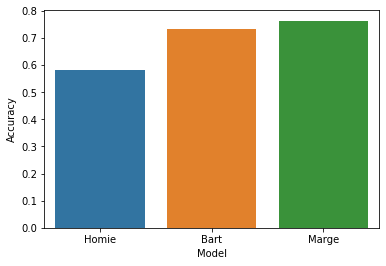

In [71]:
score_df = pd.DataFrame({"Model": ['Homie', 'Bart', 'Marge'], "Accuracy": [homie_acc, bart_score[1], marge_score[1]]})
sns.barplot(data=score_df, x="Model", y="Accuracy")

<h2> Testing on Twitter using tweepy</h2>

<h3> Setting Up API </h3>

In [15]:

auth = tweepy.OAuthHandler("FKEHI0IoW6QOqf9uwQKdDAcVP", "Ix3gDx7Q7654YUvz1M9FmYNDw05V54qak9dA9jpLg3hGMVYB0m")
auth.set_access_token('1222255868043022337-DIxKqvkevpmvyiKNHMzmYSyKdvyEpC', '2ybWYmRbZSExhEpNT6ATtL67g15lvxEH1eMq8YeXYkhij')

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")



Authentication OK


<h3> Scraping Twitter Data </h3>

In [72]:
def get_hashtag_data(ht, date_since, num_tweet=1000):
    tweep = tweepy.Cursor(api.search, q=ht, lang='en', since=date_since, tweet_mode='extended').items(num_tweet)
    tweets = [tweet for tweet in tweep]
    tweet_cont = []
    
    for tweet in tweets:
        try:
            tweet_cont.append(tweet.retweeted_status.full_text)
        except AttributeError:
            tweet_cont.append(tweet.full_text)
    tweet_text = []
    for tc in tweet_cont:
        tok = tc.split()
        tok = [t for t in tok if not t.startswith('#') and not t.startswith('http')]
        tweet_text.append(' '.join(tok))
    
    tdata = clean_data([t.split() for t in tweet_text])
    tdata = [' '.join(t) for t in tdata]
    tdata = tokenizer.texts_to_sequences(tdata)
    tdata = pad_sequences(tdata, MAX_LEN)
    
    return tdata

mcdata = get_hashtag_data('#TOMMYVLOG', '2021-04-19')
dauntedata = get_hashtag_data('#DaunteWright', '2021-04-10')

Rate limit reached. Sleeping for: 396


<h3> Analyzing Twitter Data with Neural Models </h3>

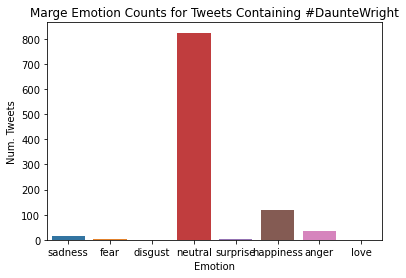

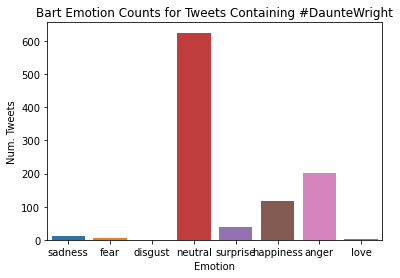

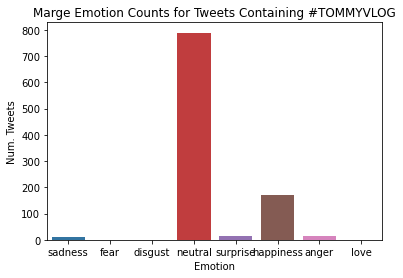

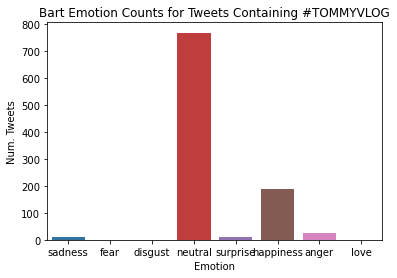

In [77]:
def classify_ht(data, model, mname, htname):
    counts = [0 for i in range(len(emo_dic))]
    for t in data:
        emot = model.predict(x=t.reshape(1, -1))
        emot = emot.reshape(-1)
        emot = emot.tolist()
        emot = emot.index(max(emot))
        counts[emot] += 1
        
        x = emo_dic.keys()
    score_df = pd.DataFrame({"Emotion": x, "Num. Tweets":counts})
    sns.barplot(data=score_df, x="Emotion", y="Num. Tweets").set_title(mname + " Emotion Counts for Tweets Containing " + htname)
    plt.show()
classify_ht(dauntedata, marge, 'Marge', '#DaunteWright')
classify_ht(dauntedata, bart, 'Bart', '#DaunteWright')
classify_ht(mcdata, marge, 'Marge', '#TOMMYVLOG')
classify_ht(mcdata, bart, 'Bart', '#TOMMYVLOG')